Using device: cuda
Label Map: {'Decision': 0, 'Post-Purchase': 1, 'Awareness': 2, 'Consideration': 3}
Added padding token '[PAD]' to tokenizer.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/local_scratch/slurm.1341950/ipykernel_146316/3963641756.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting training...


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,2.130818,0.551282,0.529490,0.701524,0.551282
2,No log,0.592320,0.794872,0.787001,0.785421,0.794872


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Evaluation Metrics: {'eval_loss': 0.5923201441764832, 'eval_accuracy': 0.7948717948717948, 'eval_f1': 0.7870005113594857, 'eval_precision': 0.7854207758053912, 'eval_recall': 0.7948717948717948, 'eval_runtime': 0.818, 'eval_samples_per_second': 190.71, 'eval_steps_per_second': 2.445, 'epoch': 2.4}


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

     Decision       0.94      0.87      0.90        70
Post-Purchase       0.46      0.39      0.42        28
    Awareness       0.80      0.95      0.87        55
Consideration       0.00      0.00      0.00         3

     accuracy                           0.79       156
    macro avg       0.55      0.55      0.55       156
 weighted avg       0.79      0.79      0.79       156



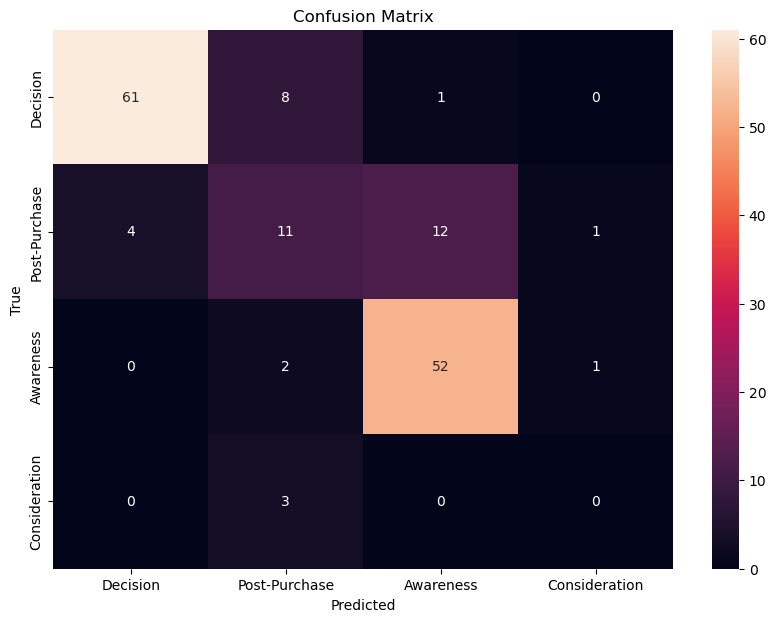

In [2]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import multiprocessing

# Ensure correct device usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
file_path = "dataset_with_topic_labels.csv"  # Replace with your dataset path
df = pd.read_csv(file_path)

# Define the stage classification logic
def classify_stage(row):
    overlap = row["topics_overlap"]
    topic = row["topic_label"]
    sentiment = row["sentiment"]
    emotional_tone = row["final_consolidated_emotional_tone"]

    if overlap >= 0.2:
        return "Post-Purchase"
    if 0.1 <= overlap < 0.2:
        if topic in ["Connectivity & Portability", "Quality & Reviews"]:
            return "Consideration"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"
    if overlap < 0.1:
        if topic in ["Design & Usability", "Protection & Packaging"]:
            return "Awareness"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"

    if emotional_tone == "Positive" and sentiment == "Positive":
        return "Post-Purchase"
    elif emotional_tone == "Neutral" or sentiment == "Neutral":
        return "Consideration"
    elif emotional_tone == "Negative" or sentiment == "Negative":
        return "Decision"
    elif emotional_tone == "Mixed":
        return "Awareness"

    return "Awareness"

# Apply classification logic
df["stage"] = df.apply(classify_stage, axis=1)

# Map labels to numerical values
label_map = {label: i for i, label in enumerate(df["stage"].unique())}
df["stage_label"] = df["stage"].map(label_map)
print("Label Map:", label_map)

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["processed_text"], df["stage_label"], test_size=0.2, random_state=42
)

# Load tokenizer and model
model_name = "meta-llama/Llama-3.2-3B"  # Replace with a smaller model for debugging if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add a padding token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print("Added padding token '[PAD]' to tokenizer.")

# Load model and resize token embeddings
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_map)
).to(device)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Define a global function for tokenization
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=256)

# Parallel tokenization using the global function
def parallel_tokenize(texts):
    with multiprocessing.Pool(processes=8) as pool:  # Adjust process count based on resources
        tokenized = pool.map(tokenize_function, texts)
    return {
        key: torch.tensor([item[key] for item in tokenized])
        for key in tokenized[0]
    }

# Perform tokenization
train_encodings = parallel_tokenize(train_texts.tolist())  # Convert to list for multiprocessing
val_encodings = parallel_tokenize(val_texts.tolist())

train_encodings["labels"] = torch.tensor(train_labels.tolist())
val_encodings["labels"] = torch.tensor(val_labels.tolist())

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(train_encodings)
val_dataset = Dataset.from_dict(val_encodings)

# Define evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Optimized batch size
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    gradient_accumulation_steps=2,  # Simulate larger batch size
    fp16=True,  # Enable mixed precision training
    optim="adamw_bnb_8bit",  # Efficient optimizer
    report_to="none"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# Analyze performance for a specific class
y_true = val_labels.tolist()
y_pred = trainer.predict(val_dataset).predictions.argmax(-1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from torch.utils.data import Dataset

# Disable DeepSpeed and CUDA if necessary
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Force CPU if needed

# Load dataset
file_path = "dataset_with_topic_labels.csv"
df = pd.read_csv(file_path)

def classify_stage(row):
    overlap = row["topics_overlap"]
    topic = row["topic_label"]
    sentiment = row["sentiment"]
    emotional_tone = row["final_consolidated_emotional_tone"]

    if overlap >= 0.2:
        return "Post-Purchase"
    if 0.1 <= overlap < 0.2:
        if topic in ["Connectivity & Portability", "Quality & Reviews"]:
            return "Consideration"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"
    if overlap < 0.1:
        if topic in ["Design & Usability", "Protection & Packaging"]:
            return "Awareness"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"

    if emotional_tone == "Positive" and sentiment == "Positive":
        return "Post-Purchase"
    elif emotional_tone == "Neutral" or sentiment == "Neutral":
        return "Consideration"
    elif emotional_tone == "Negative" or sentiment == "Negative":
        return "Decision"
    elif emotional_tone == "Mixed":
        return "Awareness"

    return "Awareness"

# Apply classify_stage
df["stage"] = df.apply(classify_stage, axis=1)

# Create label map
label_map = {label: i for i, label in enumerate(df["stage"].unique())}
print("Label Map:", label_map)

# Define custom dataset
class CommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length)
        self.labels = [label_map[label] for label in labels]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["processed_text"], df["stage"], test_size=0.2, random_state=42
)

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

train_dataset = CommentsDataset(train_texts, train_labels, tokenizer)
val_dataset = CommentsDataset(val_texts, val_labels, tokenizer)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs",
    learning_rate=2e-5,
    fp16=False,  # Avoid mixed precision
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train
print("Starting training...")
trainer.train()

# Evaluate
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# Extract true and predicted labels
predictions, labels, _ = trainer.predict(val_dataset)
y_pred = predictions.argmax(-1)
y_true = labels

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

# Calculate metrics for "Awareness"
awareness_label = label_map["Awareness"]

# Total number of true "Awareness" samples
total_awareness = sum(y_true == awareness_label)

# Number of correct "Awareness" predictions
correct_awareness = sum((y_true == awareness_label) & (y_pred == awareness_label))

# Calculate precision, recall, and accuracy for "Awareness"
precision_awareness = correct_awareness / sum(y_pred == awareness_label) if sum(y_pred == awareness_label) > 0 else 0
recall_awareness = correct_awareness / total_awareness if total_awareness > 0 else 0
accuracy_awareness = correct_awareness / len(y_true)

print(f"\nMetrics for 'Awareness':")
print(f"Total 'Awareness' Samples: {total_awareness}")
print(f"Correct 'Awareness' Predictions: {correct_awareness}")
print(f"Precision: {precision_awareness:.2f}")
print(f"Recall: {recall_awareness:.2f}")
print(f"Accuracy: {accuracy_awareness:.2f}")


Using device: cuda
Label Map: {'Decision': 0, 'Post-Purchase': 1, 'Awareness': 2, 'Consideration': 3}
Added padding token '[PAD]' to tokenizer.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/local_scratch/slurm.1341950/ipykernel_146316/1707659047.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting training...


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,10.018370,0.352564,0.183801,0.124301,0.352564
2,No log,0.497216,0.839744,0.828676,0.833156,0.839744
4,No log,0.353826,0.858974,0.857431,0.857076,0.858974
6,No log,0.270394,0.891026,0.879107,0.876709,0.891026


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packag

In [2]:
pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/d1/35/e8b2daf02ce933e4518e6f5682c72fd0ed66c15910ea1fb4168f442b71c4/torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/de/e9/e190ecec448d5a2abad8348cf085fcb39962a491e3f40dcb023721e04feb/torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/41/33/0f21b15f8e231bb55578f6b32e8c18675585b7bf97cb0aee96b1591e4193/torchaudio-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Obtaining dependency information f

In [3]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import multiprocessing

# Ensure correct device usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
file_path = "dataset_with_topic_labels.csv"  # Replace with your dataset path
df = pd.read_csv(file_path)

# Define the stage classification logic
def classify_stage(row):
    overlap = row["topics_overlap"]
    topic = row["topic_label"]
    sentiment = row["sentiment"]
    emotional_tone = row["final_consolidated_emotional_tone"]

    if overlap >= 0.2:
        return "Post-Purchase"
    if 0.1 <= overlap < 0.2:
        if topic in ["Connectivity & Portability", "Quality & Reviews"]:
            return "Consideration"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"
    if overlap < 0.1:
        if topic in ["Design & Usability", "Protection & Packaging"]:
            return "Awareness"
        if topic in ["Performance & Specifications", "Quality & Reviews"]:
            return "Decision"

    if emotional_tone == "Positive" and sentiment == "Positive":
        return "Post-Purchase"
    elif emotional_tone == "Neutral" or sentiment == "Neutral":
        return "Consideration"
    elif emotional_tone == "Negative" or sentiment == "Negative":
        return "Decision"
    elif emotional_tone == "Mixed":
        return "Awareness"

    return "Awareness"

# Apply classification logic
df["stage"] = df.apply(classify_stage, axis=1)

# Map labels to numerical values
label_map = {label: i for i, label in enumerate(df["stage"].unique())}
df["stage_label"] = df["stage"].map(label_map)
print("Label Map:", label_map)

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["processed_text"], df["stage_label"], test_size=0.2, random_state=42
)

# Load tokenizer and model
model_name = "meta-llama/Llama-3.2-3B"  # Replace with a smaller model for debugging if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add a padding token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print("Added padding token '[PAD]' to tokenizer.")

# Load model and resize token embeddings
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_map)
).to(device)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Define a global function for tokenization
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=256)

# Parallel tokenization using the global function
def parallel_tokenize(texts):
    with multiprocessing.Pool(processes=8) as pool:  # Adjust process count based on resources
        tokenized = pool.map(tokenize_function, texts)
    return {
        key: torch.tensor([item[key] for item in tokenized])
        for key in tokenized[0]
    }

# Perform tokenization
train_encodings = parallel_tokenize(train_texts.tolist())  # Convert to list for multiprocessing
val_encodings = parallel_tokenize(val_texts.tolist())

train_encodings["labels"] = torch.tensor(train_labels.tolist())
val_encodings["labels"] = torch.tensor(val_labels.tolist())

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(train_encodings)
val_dataset = Dataset.from_dict(val_encodings)

# Define evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir=None,  # Avoid saving checkpoints to disk
    num_train_epochs=10,
    per_device_train_batch_size=16,  # Optimized batch size
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="no",  # Disable saving checkpoints
    logging_dir=None,  # Avoid saving logs to disk
    logging_steps=100,
    learning_rate=2e-5,
    gradient_accumulation_steps=2,  # Simulate larger batch size
    fp16=True,  # Enable mixed precision training
    optim="adamw_bnb_8bit",  # Efficient optimizer
    report_to="none"  # Disable reporting
)


# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# Analyze performance for a specific class
y_true = val_labels.tolist()
y_pred = trainer.predict(val_dataset).predictions.argmax(-1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


ModuleNotFoundError: No module named 'torch'